# Import Libraries

In [16]:
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import joblib

# Read Data

In [17]:
data = pd.read_csv("NSCLC.csv")
pd.set_option('display.max_columns', None)
data.tail()

,Case ID,Patient affiliation,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,Pack Years,Quit Smoking Year,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),Tumor Location (choice=LLL),Tumor Location (choice=L Lingula),Tumor Location (choice=Unknown),Histology,Pathological T stage,Pathological N stage,Pathological M stage,Histopathological Grade,Lymphovascular invasion,"Pleural invasion (elastic, visceral, or parietal)",EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Recurrence Location,Date of Recurrence,Date of Last Known Alive,Survival Status,Date of Death,Time to Death (days),CT Date,Days between CT and surgery,PET Date
206,R01-159,Stanford,75,184,Male,Caucasian,Former,55,1994.0,Not Assessed,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Squamous cell carcinoma,T2a,N1,M0,G2 Moderately differentiated,Absent,No,Unknown,Unknown,Unknown,No,No,No,no,NaN,NaN,7/13/1995,Alive,NaN,NaN,11/24/1994,14,11/16/1994
207,R01-160,VA,61,231.5,Male,Caucasian,Former,12,1993.0,Not Assessed,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T3,N0,M0,"Other, Type II: Moderately to poorly different...",Absent,No,Unknown,Mutant,Unknown,Yes,Yes,No,no,NaN,NaN,7/3/1999,Alive,NaN,NaN,8/12/1993,72,9/22/1993
208,R01-161,Stanford,52,Not Collected,Female,Caucasian,Former,7,NaN,Not Assessed,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T2a,N0,M0,G2 Moderately differentiated,Absent,No,Wildtype,Wildtype,Wildtype,No,No,No,no,NaN,NaN,4/2/1999,Alive,NaN,NaN,12/13/1995,8,9/26/1995
209,R01-162,Stanford,67,158,Male,Asian,Former,15,1966.0,Not Assessed,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T2a,N0,M0,G1 Well differentiated,Absent,No,Mutant,Wildtype,Wildtype,No,No,No,no,NaN,NaN,10/8/1997,Dead,10/8/1997,671.0,10/3/1995,65,11/14/1995
210,R01-163,VA,68,229,Male,Caucasian,Current,30,NaN,Not Assessed,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,NSCLC NOS (not otherwise specified),T1a,N0,M0,G3 Poorly differentiated,Not Collected,Not collected,Not collected,Not collected,Not collected,Yes,Yes,No,yes,distant,2/15/1996,1/11/1997,Dead,1/11/1997,462.0,8/17/1995,51,7/12/1995


# Preprocessing 

In [18]:
tumor_columns = [
    'Tumor Location (choice=RUL)',
    'Tumor Location (choice=RML)',
    'Tumor Location (choice=RLL)',
    'Tumor Location (choice=LUL)',
    'Tumor Location (choice=LLL)',
    'Tumor Location (choice=L Lingula)'
]
def get_tumor_location(row):
    for col in tumor_columns:
        if row[col] == 'Checked':
            return col.split('=')[1].replace(')', '').replace('(', '').strip() 
    return 'Unknown' 
data['Tumor Location'] = data.apply(get_tumor_location, axis=1)

In [19]:
columns_to_drop = [
    'Patient affiliation',  # refere to the medical institution "stanford, VA"
    'Quit Smoking Year', #the year when a patient who was previously a smoker stopped smoking "ex:1994"
    '%GG', # stands for Percentage of Ground-Glass Opacity "related with the CT images"
    'Tumor Location (choice=Unknown)', # all tumor location is known 
    'Histology ', # all is adenocarcinoma
    'Date of Recurrence', # EX 10/7/1994
    'Date of Last Known Alive', # 
    'Date of Death', #
    'CT Date', # depend on radio images 
    'Days between CT and surgery', # depend on radio images  
    'PET Date', # depend on radio images 
    'Case ID', # it is not important for the model to know the id 
    'Tumor Location (choice=RUL)', # collect in one column named Tumor Location
    'Tumor Location (choice=RML)', # collect in one column named Tumor Location
    'Tumor Location (choice=RLL)', # collect in one column named Tumor Location
    'Tumor Location (choice=LUL)', # collect in one column named Tumor Location
    'Tumor Location (choice=LLL)', # collect in one column named Tumor Location
    'Tumor Location (choice=L Lingula)' # collect in one column named Tumor Location
]

data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

In [20]:
warnings.filterwarnings("ignore")
data['Recurrence Location'] = data['Recurrence Location'].fillna('No')
data['Pack Years'].fillna(0, inplace=True)
data['Time to Death (days)'].fillna(0, inplace=True)

In [21]:
data.replace(['Not Collected', 'Not Recorded In Database', 'Not collected', 'Unknown'], np.nan, inplace=True)

In [22]:
gender_encoding = {
    'Female': 0,
    'Male': 1
}

data['Gender'] = data['Gender'].map(gender_encoding)

Ethnicity_encoding = {
    'Caucasian': 0,
    'Asian': 1,
    'Native Hawaiian/Pacific Islander': 2,
    'African-American': 3,
    'Hispanic/Latino': 4
}

data['Ethnicity'] = data['Ethnicity'].map(Ethnicity_encoding)

Smoking_status_encoding = {
    'Nonsmoker': 0,
    'Current': 1,
    'Former': 2
}

location_encoding = {
    'RUL': 0,
    'RML': 1,
    'RLL': 2,
    'LUL': 3,
    'LLL': 4,
    'L Lingula': 5
}

data['Tumor Location'] = data['Tumor Location'].map(location_encoding)

data['Smoking status'] = data['Smoking status'].map(Smoking_status_encoding)

Pathological_T_stage_encoding = {
    'Tis': 0,
    'T1a': 1,
    'T1b': 2,
    'T2a': 3,
    'T2b': 4,
    'T3': 5,
    'T4': 6  
}
data['Pathological T stage'] = data['Pathological T stage'].map(Pathological_T_stage_encoding)

Pathological_N_stage_encoding = {
    'N0': 0,
    'N1': 1,
    'N2': 2
}

data['Pathological N stage'] = data['Pathological N stage'].map(Pathological_N_stage_encoding)

Pathological_M_stage_encoding = {
    'M0': 0,
    'M1a': 1,
    'M1b': 2
}

data['Pathological M stage'] = data['Pathological M stage'].map(Pathological_M_stage_encoding)

Histopathological_Grade_encoding = {
    'G1 Well differentiated': 0,
    'Other, Type I: Well to moderately differentiated': 1,
    'G2 Moderately differentiated': 2,
    'Other, Type II: Moderately to poorly differentiated': 3,
    'G3 Poorly differentiated': 4
    
}

data['Histopathological Grade'] = data['Histopathological Grade'].map(Histopathological_Grade_encoding)

Lymphovascular_invasion_encoding = {
    'Absent': 0,
    'Present': 1
}

data['Lymphovascular invasion'] = data['Lymphovascular invasion'].map(Lymphovascular_invasion_encoding)

Pleural_invasion_encoding = {
    'No': 0,
    'Yes': 1
}

data['Pleural invasion (elastic, visceral, or parietal)'] = data['Pleural invasion (elastic, visceral, or parietal)'].map(Pleural_invasion_encoding)

EGFR_mutation_status_encoding = {
    'Wildtype': 0,
    'Mutant': 1
}

data['EGFR mutation status'] = data['EGFR mutation status'].map(EGFR_mutation_status_encoding)

KRAS_mutation_status_encoding = {
    'Wildtype': 0,
    'Mutant': 1
}

data['KRAS mutation status'] = data['KRAS mutation status'].map(KRAS_mutation_status_encoding)

ALK_translocation_status_encoding = {
    'Wildtype': 0,
    'Translocated': 1
}

data['ALK translocation status'] = data['ALK translocation status'].map(ALK_translocation_status_encoding)

Adjuvant_Treatment_encoding = {
    'No': 0,
    'Yes': 1
}

data['Adjuvant Treatment'] = data['Adjuvant Treatment'].map(Adjuvant_Treatment_encoding)

Chemotherapy_encoding = {
    'No': 0,
    'Yes': 1
}

data['Chemotherapy'] = data['Chemotherapy'].map(Chemotherapy_encoding)

Radiation_encoding = {
    'No': 0,
    'Yes': 1
}

data['Radiation'] = data['Radiation'].map(Radiation_encoding)

Recurrence_encoding = {
    'no': 0,
    'yes': 1
}

data['Recurrence'] = data['Recurrence'].map(Recurrence_encoding)

Recurrence_Location_encoding = {
    'No': 0,       
    'local': 1,    
    'regional': 2, 
    'distant': 3   
}


data['Recurrence Location'] = data['Recurrence Location'].map(Recurrence_Location_encoding)

Survival_Status_encoding = {
    'Dead': 0,
    'Alive': 1
}

data['Survival Status'] = data['Survival Status'].map(Survival_Status_encoding)

In [23]:
data['Weight (lbs)'] = data['Weight (lbs)'].astype(float)
data['Pack Years'] = data['Pack Years'].astype(float)

In [24]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [25]:
missing_values = data.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Weight (lbs)                                         59
Ethnicity                                            49
Pack Years                                            8
Pathological T stage                                 49
Pathological N stage                                 49
Pathological M stage                                 49
Histopathological Grade                              49
Lymphovascular invasion                              57
Pleural invasion (elastic, visceral, or parietal)    52
EGFR mutation status                                 39
KRAS mutation status                                 40
ALK translocation status                             54
Adjuvant Treatment                                    1
Chemotherapy                                          1
Radiation                                             1
Recurrence                                            1
dtype: int64


In [26]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
for column in ['Pathological T stage', 'Pathological N stage', 'Pathological M stage', 'Histopathological Grade']:
    if column in data.columns:
        most_common_value = data[column].mode()[0]
        data[column].fillna(most_common_value, inplace=True)

In [28]:
imputer = KNNImputer(n_neighbors=5)

columns_to_impute = [
    'Weight (lbs)', 
    'Ethnicity', 
    'Pack Years', 
    'Pathological T stage', 
    'Pathological N stage', 
    'Pathological M stage', 
    'Histopathological Grade', 
    'Lymphovascular invasion', 
    'Pleural invasion (elastic, visceral, or parietal)', 
    'EGFR mutation status', 
    'KRAS mutation status', 
    'ALK translocation status', 
    'Adjuvant Treatment', 
    'Chemotherapy', 
    'Radiation', 
    'Recurrence'
]

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

data['Weight (lbs)'] = data['Weight (lbs)']
data['Pack Years'] = data['Pack Years']
data['Pathological T stage'] = data['Pathological T stage']
data['Pathological N stage'] = data['Pathological N stage']
data['Pathological M stage'] = data['Pathological M stage']
data['Histopathological Grade'] = data['Histopathological Grade']
data['Lymphovascular invasion'] = data['Lymphovascular invasion']
data['Pleural invasion (elastic, visceral, or parietal)'] = data['Pleural invasion (elastic, visceral, or parietal)']
data['EGFR mutation status'] = data['EGFR mutation status']
data['KRAS mutation status'] = data['KRAS mutation status']
data['ALK translocation status'] = data['ALK translocation status']
data['Adjuvant Treatment'] = data['Adjuvant Treatment']
data['Chemotherapy'] = data['Chemotherapy']
data['Radiation'] = data['Radiation']
data['Recurrence'] = data['Recurrence']

# Feature Selection

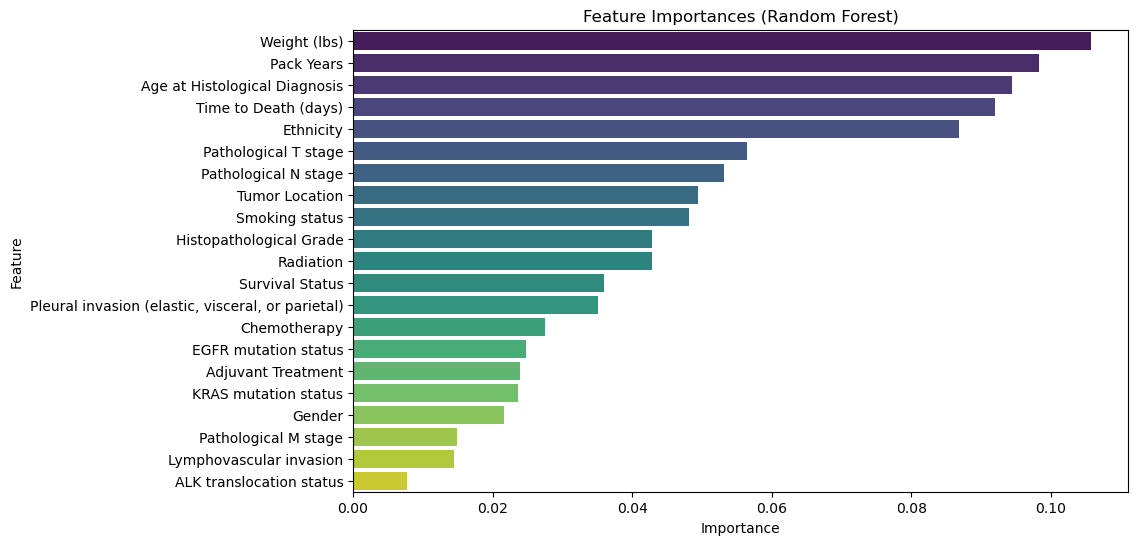

In [29]:
y = data[['Recurrence', 'Recurrence Location']].apply(lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

X = data.drop(['Recurrence', 'Recurrence Location'], axis=1)

y_encoded = pd.factorize(y)[0] 

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

indices = importances.argsort()[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Support Vector Machine(SVM)

In [1672]:
feature_columns = [
    'Age at Histological Diagnosis', 'Weight (lbs)', 'Gender', 'Ethnicity',
    'Smoking status', 'Tumor Location', 'Pathological T stage',
    'Pathological N stage',
    'EGFR mutation status', 'KRAS mutation status',
    'ALK translocation status','Chemotherapy',
    'Radiation', 'Survival Status','Time to Death (days)'
]

X = data[feature_columns]
y = data[['Recurrence', 'Recurrence Location']]  

y_combined = y.apply(lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

class_counts = y_combined.value_counts()

rare_classes = class_counts[class_counts == 1].index
data_filtered = data[~y_combined.isin(rare_classes)]

X_filtered = data_filtered[feature_columns]
y_filtered = data_filtered[['Recurrence', 'Recurrence Location']].apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

y_encoded = pd.factorize(y_filtered)[0]

X_filtered.fillna(X_filtered.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

train_acc_svm = accuracy_score(y_train, svm_model.predict(X_train_scaled))
test_acc_svm = accuracy_score(y_test, svm_model.predict(X_test_scaled))

print(f"SVM Train Accuracy: {train_acc_svm * 100:.2f}%")
print(f"SVM Test Accuracy: {test_acc_svm * 100:.2f}%")

SVM Train Accuracy: 80.95%
SVM Test Accuracy: 79.07%


# Extreme Gradient Boosting (xgboost)

In [30]:
feature_columns = [
    'Age at Histological Diagnosis', 'Weight (lbs)', 'Gender',
    'Smoking status','Tumor Location', 'Pathological T stage',
    'Pathological N stage', 'Pathological M stage',
    'Histopathological Grade', 'Lymphovascular invasion',
    'EGFR mutation status', 'KRAS mutation status',
    'ALK translocation status', 'Adjuvant Treatment', 'Chemotherapy',
    'Radiation','Survival Status'
]

X = data[feature_columns]
y = data[['Recurrence', 'Recurrence Location']]

y_combined = y.apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

class_counts = y_combined.value_counts()
rare_classes = class_counts[class_counts == 1].index
data_filtered = data[~y_combined.isin(rare_classes)]

X_filtered = data_filtered[feature_columns]
y_filtered = data_filtered[['Recurrence', 'Recurrence Location']].apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)

train_acc_xgb = accuracy_score(y_train, xgb_model.predict(X_train_scaled))
test_acc_xgb = accuracy_score(y_test, xgb_model.predict(X_test_scaled))

print(f"XGBoost Train Accuracy: {train_acc_xgb * 100:.2f}%")
print(f"XGBoost Test Accuracy: {test_acc_xgb * 100:.2f}%")


XGBoost Train Accuracy: 100.00%
XGBoost Test Accuracy: 74.42%


# Random Forest

In [31]:
feature_columns = [
    'Age at Histological Diagnosis', 'Weight (lbs)', 'Gender', 'Ethnicity',
    'Smoking status', 'Tumor Location', 'Pathological T stage',
    'Pathological N stage',
    'EGFR mutation status', 'KRAS mutation status',
    'ALK translocation status','Chemotherapy',
    'Radiation', 'Survival Status','Time to Death (days)'
]

X = data[feature_columns]
y = data[['Recurrence', 'Recurrence Location']] 

y_combined = y.apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

class_counts = y_combined.value_counts()
rare_classes = class_counts[class_counts == 1].index
data_filtered = data[~y_combined.isin(rare_classes)] 

X_filtered = data_filtered[feature_columns]
y_filtered = data_filtered[['Recurrence', 'Recurrence Location']].apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=7,     
    bootstrap=False,  
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

train_acc_rf = accuracy_score(y_train, rf_model.predict(X_train_scaled))
test_acc_rf = accuracy_score(y_test, rf_model.predict(X_test_scaled))

print(f"Random Forest Train Accuracy: {train_acc_rf * 100:.2f}%")
print(f"Random Forest Test Accuracy: {test_acc_rf * 100:.2f}%")

Random Forest Train Accuracy: 96.43%
Random Forest Test Accuracy: 86.05%


In [32]:
X = data[feature_columns]
y = data[['Recurrence', 'Recurrence Location']]

y_combined = y.apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

class_counts = y_combined.value_counts()
rare_classes = class_counts[class_counts == 1].index
data_filtered = data[~y_combined.isin(rare_classes)] 

X_filtered = data_filtered[feature_columns]
y_filtered = data_filtered[['Recurrence', 'Recurrence Location']].apply(
    lambda row: f"{row['Recurrence']}_{row['Recurrence Location']}", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=7,     
    bootstrap=False,  
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation Accuracy Scores: {cv_scores}")

print(f"Best Cross-validation Accuracy: {cv_scores.max() * 100:.2f}%")

rf_model.fit(X_train_scaled, y_train)

train_acc_rf = accuracy_score(y_train, rf_model.predict(X_train_scaled))
test_acc_rf = accuracy_score(y_test, rf_model.predict(X_test_scaled))

print(f"Random Forest Train Accuracy: {train_acc_rf * 100:.2f}%")
print(f"Random Forest Test Accuracy: {test_acc_rf * 100:.2f}%")

Cross-validation Accuracy Scores: [0.82352941 0.76470588 0.61764706 0.78787879 0.81818182]
Best Cross-validation Accuracy: 82.35%
Random Forest Train Accuracy: 96.43%
Random Forest Test Accuracy: 86.05%


# Save Model

In [33]:
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [34]:
joblib.dump(scaler, "min_scaler.pkl")

['min_scaler.pkl']